In [679]:
import os, glob, numpy as np, joblib as jl, pandas as pd, \
    matplotlib.pyplot as plt, simplification.cutil as simpl, numba as nb
from scipy.stats import mode
from scipy.optimize import minimize
from tqdm import tqdm_notebook as tqdm
from plotnine import *
import warnings
import seaborn as sns
import regex as re
import simplification.cutil as simpl
warnings.filterwarnings('ignore')

### Outward -> Inward

In [4]:
# Load data
fnames = glob.glob('C:/Users/acorver/Desktop/data-tmp/radiidata_*.metrics.pickle')
len(fnames)

21

In [5]:
def computeOutwardInwardAngles(recid, fn, interpolate=True, zeroIntercept=True):
    dRadii = jl.load(fn)
    # Use zero-intercept angle
    if zeroIntercept:
        dRadii.angle = dRadii.angleZeroIntercept
    
    stagerep = 0 
    anglesAll = []
    
    for stagerep in range(dRadii.stagerep.max()+1):
        dr = dRadii[(dRadii.stage == 'radii')&(dRadii.stagerep==stagerep)].reset_index().copy()
        
        i = 0
        pairsOutwardInward = []
        done = False
        while True:
            # Find next outward-inward radius pair
            while not (dr.outward[i] and not dr.outward[i+1]):
                i += 1
                if i >= dr.shape[0]-1:
                    done=True
                    break
            if done:
                break
            iOutward = i
            iInward = i+1
            i += 1
            # Store pair
            pairsOutwardInward.append((iOutward, iInward))

        angles = [abs(dr.angle[p[0]] - dr.angle[p[1]]) for p in pairsOutwardInward]
        angles = [min(2 * np.pi - a, a) for a in angles]
        
        timerel = []
        for p in pairsOutwardInward:
            vmin = np.min([x[0] for x in pairsOutwardInward])
            vmax = np.max([x[1] for x in pairsOutwardInward])
            timerel.append((0.5*(p[0]+p[1])-vmin)/(vmax - vmin))
            
        stageSpan = [(dr.startframe[p[0]],
                      dr.stage_start[p[0]], 
                      dr.stage_end[p[0]]) for p in pairsOutwardInward]
        
        anglesAll += [(recid, tr, stagerep, a, stsp[0], stsp[1], stsp[2]) for \
                      a, tr, stsp in zip(angles, timerel, stageSpan)]
    
    anglesAll += [
        (recid, 0.0, -1, -1),
        (recid, 5.0, -1, -1)
    ]
    
    d = pd.DataFrame(anglesAll, columns=['recid', 'timerel', 'stagerep', 'angledelta', 'startframe', 'stage_start', 'stage_end'])
    
    d.loc[:,'timerel_stage'] = (d.startframe - d.stage_start) / (d.stage_end - d.stage_start)
    
    # Test:
    d.timerel = d.timerel_stage
    
    if interpolate:
        d.loc[:,'_timerel'] = d.timerel + 1.0 * d.stagerep
        d.loc[:,'_timerelH'] = pd.to_timedelta(d._timerel, unit="h")
        d = d.resample('1s', on='_timerelH').mean().reset_index()
        d._timerel = d._timerelH / np.timedelta64(3600, 's')
        d = d.interpolate(method='nearest')
        d = d[(d.stagerep >= 0)&(d._timerel >= 0)]
    else:
        d = d[(d.stagerep >= 0)]
    
    return d

In [ ]:
data = pd.concat([computeOutwardInwardAngles(fni, fn, interpolate=False, zeroIntercept=True) \
                  for fni, fn in tqdm(enumerate(fnames))])

In [511]:
dataInterpolated = []
for recid in data.recid.unique():
    for stagerep in data[data.recid==recid].stagerep.unique():
        d = data[(data.recid == recid)&(data.stagerep==stagerep)].copy()
        d = d.set_index('timerel_stage')
        d = pd.DataFrame(d.angledelta).rolling(window=5, center=True).agg({'angledelta': ['min', 'max']})
        d = d.fillna(method='ffill').fillna(method='bfill')
        d.loc[:,'maxmingap'] = d.angledelta.loc[:,'max'] - d.angledelta.loc[:,'min']
        t = np.linspace(0, 1.0, 1001)
        _idx = d.index.values
        #_idx = np.linspace(0, 1.0, d.index.values.shape[0])
        yvalsMin = interp1d(_idx, d.angledelta.loc[:,'min'].values, fill_value='extrapolate')(t)
        yvalsMax = interp1d(_idx, d.angledelta.loc[:,'max'].values, fill_value='extrapolate')(t)
        yvalsGap = interp1d(_idx, d.loc[:,'maxmingap'].values, fill_value='extrapolate')(t)
        for _t, _min, _max, _gap in zip(t, yvalsMin, yvalsMax, yvalsGap):
            dataInterpolated.append((recid, stagerep, _t, _min, _max, _gap))
dataInterpolated = pd.DataFrame(dataInterpolated, columns=[
    'recid', 'stagerep', 't', 'angledelta_min', 'angledelta_max', 'angledelta_gap'])

In [487]:
# Source: http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html
def bootstrap(data, n=1000, func=np.nanmean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

In [ ]:
dataCI = []
for stagerep in tqdm(dataInterpolated.stagerep.unique(), leave=False):
    for _t in tqdm(np.linspace(0, 1.0, 101), leave=False):
        vMin = dataInterpolated.loc[(dataInterpolated.stagerep==stagerep)&(dataInterpolated.t==_t), 'angledelta_min']
        vMax = dataInterpolated.loc[(dataInterpolated.stagerep==stagerep)&(dataInterpolated.t==_t), 'angledelta_max']
        ciMin50 = (np.nanpercentile(vMin, 25), np.nanpercentile(vMin, 75))
        ciMax50 = (np.nanpercentile(vMax, 25), np.nanpercentile(vMax, 75))
        ciMin90 = (np.nanpercentile(vMin, 2.5), np.nanpercentile(vMin, 97.5))
        ciMax90 = (np.nanpercentile(vMax, 2.5), np.nanpercentile(vMax, 97.5))
        ciGap50 = (0,0)
        ciGap90 = (0,0)
        dataCI.append((stagerep, ciMin50[0], ciMin50[1], ciMax50[0], ciMax50[1], ciGap50[0], ciGap50[1], 
                                 ciMin90[0], ciMin90[1], ciMax90[0], ciMax90[1], ciGap90[0], ciGap90[1], 
                                 np.nanmedian(vMin), np.nanmedian(vMax)))
dataCI = pd.DataFrame(dataCI, columns=['stagerep', 'min25', 'min75', 'max25', 'max75', 'gap25', 'gap75',
                                                   'min5', 'min95', 'max5', 'max95', 'gap5', 'gap95', 
                                       'minMedian', 'maxMedian'])

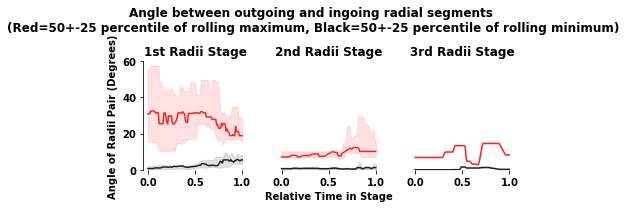

In [728]:
fig, ax = plt.subplots(1, 3, figsize=(6, 3))

for stagerep in range(3):
    xs = np.linspace(0, 1.0, 101)
    ax[stagerep].plot(xs, dataCI.minMedian[dataCI.stagerep==stagerep] * 180 / np.pi, color='#222222')
    ax[stagerep].plot(xs, dataCI.maxMedian[dataCI.stagerep==stagerep] * 180 / np.pi, color='#ff2222')
    
    ax[stagerep].fill_between(xs, 
                     dataCI.min25[dataCI.stagerep==stagerep] * 180 / np.pi, 
                     dataCI.min75[dataCI.stagerep==stagerep] * 180 / np.pi, color='#888888', alpha=0.25)
    ax[stagerep].fill_between(xs, 
                     dataCI.max25[dataCI.stagerep==stagerep] * 180 / np.pi, 
                     dataCI.max75[dataCI.stagerep==stagerep] * 180 / np.pi, color='#ff8888', alpha=0.25)
    
    if stagerep != 0:
        ax[stagerep].spines["left"].set_visible(False)
        ax[stagerep].get_yaxis().set_visible(False)
    ax[stagerep].spines["top"].set_visible(False)
    ax[stagerep].spines["right"].set_visible(False)
    ax[stagerep].spines["bottom"].set_visible(False)
    
    ax[stagerep].set_title('{} Radii Stage'.format(['1st', '2nd', '3rd'][stagerep]))
    if stagerep == 1:
        ax[stagerep].set_xlabel('Relative Time in Stage')
    if stagerep == 0:
        ax[stagerep].set_ylabel('Angle of Radii Pair (Degrees)')
    
    ax[stagerep].set_ylim(0, 60)

fig.suptitle('Angle between outgoing and ingoing radial segments \n(Red=50+-25 percentile of rolling maximum, Black=50+-25 percentile of rolling minimum)\n')    
fig.tight_layout(rect=[0, 0.03, 1, 0.85])

fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_radii_pt2.pdf')

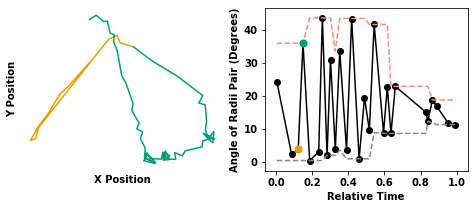

In [731]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

recid = 0

dXY = jl.load(fnames[recid].replace('.metrics', ''))
dXY = np.load(dXY['fname'])
dXY = dXY[:, 0, :2]

d = data[data.recid == recid].copy()
d.angledelta *= 180 / np.pi

tA0, tA1 = d.iloc[2].timerel, d.iloc[2+1].timerel
tB0, tB1 = d.iloc[3].timerel, d.iloc[3+1].timerel

s0 = d.stage_start[d.stagerep==0].values[0]
s1 = d.stage_end[d.stagerep==0].values[0]

f0 = int(s0 * (1-tA0) + tA0 * s1)
f1 = int(s0 * (1-tA1) + tA1 * s1) + 1
xyA = dXY[f0:f1, :]
xyA = pd.DataFrame(xyA).fillna(method='ffill').fillna(method='bfill').values

f0 = int(s0 * (1-tB0) + tB0 * s1)
f1 = int(s0 * (1-tB1) + tB1 * s1) + 1
xyB = dXY[f0:f1, :]
xyB = pd.DataFrame(xyB).fillna(method='ffill').fillna(method='bfill').values

resVW = 200
xyA = simpl.simplify_coords_vw(xyA.copy(), resVW)
xyB = simpl.simplify_coords_vw(xyB.copy(), resVW)

colA = '#e69f00'
colB = '#009E73'

ax[0].plot(xyA[:,0], xyA[:,1], color=colA)
ax[0].plot(xyB[:,0], xyB[:,1], color=colB)

ax[1].plot(d.timerel_stage + d.stagerep, d.angledelta, color='black')
ax[1].scatter(d.timerel_stage + d.stagerep, d.angledelta, color='black')

ax[1].scatter(d.iloc[2].timerel_stage, d.iloc[2].angledelta, color=colA, zorder=10, s=50)
ax[1].scatter(d.iloc[3].timerel_stage, d.iloc[3].angledelta, color=colB, zorder=10, s=50)

v1 = pd.DataFrame(d.angledelta).rolling(window=5, center=True).max().fillna(method='ffill').fillna(method='bfill')
v2 = pd.DataFrame(d.angledelta).rolling(window=5, center=True).min().fillna(method='ffill').fillna(method='bfill')
ax[1].plot(d.timerel_stage + d.stagerep, v1, linestyle='--', color='#ff8888')
ax[1].plot(d.timerel_stage + d.stagerep, v2, linestyle='--', color='#888888')

ax[0].spines["left"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].set_xticklabels([])
ax[0].set_xticks([])
ax[0].set_yticklabels([])
ax[0].set_yticks([])
ax[0].set_xlabel('X Position')
ax[0].set_ylabel('Y Position')

ax[1].set_xlabel('Relative Time')
ax[1].set_ylabel('Angle of Radii Pair (Degrees)')

fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_radii_pt1.pdf')